In [13]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix, kron
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.sparse import csr_matrix, csc_matrix, kron, identity
from scipy.sparse.linalg import expm

large = 40; med = 30; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
#plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

In [14]:
I2 = csc_matrix(np.eye(2))
sigma_x = csc_matrix(np.array([[0, 1], [1, 0]]))
sigma_y = csc_matrix(np.array([[0, -1j], [1j, 0]]))
sigma_z = csc_matrix(np.array([[1, 0], [0, -1]]))
sigma_plus = (sigma_x + 1j * sigma_y).toarray() / 2
sigma_minus = (sigma_x - 1j * sigma_y).toarray() / 2

# Cost function construction

In [15]:
def vectorize_rho(rho):
     rho = rho.toarray()
     rho_vec = rho.flatten(order="F")
     return csc_matrix(rho_vec).T

def unvectorize_rho(rho_vec):
    if hasattr(rho_vec, "toarray"):
        rho=rho_vec.toarray().reshape((2,2), order="F")
    else:
        rho=rho_vec.reshape((2,2), order="F")
    return csc_matrix(rho)
gamma_1 = 0.6
gamma_2 = 0.7
Delta = 0.7

L = 1
J = 1
gamma_r = gamma_1
gamma_d = gamma_2

L_1 = sigma_minus
L_2 = (I2+sigma_z)/2

def L_int(x):
     return -1j * (kron(I2, J * L * x * sigma_x) - kron(J * L * x * sigma_x, I2))
def L_f():
     return -1j * (kron(I2, - Delta * sigma_z) - kron(- Delta * sigma_z, I2))

def L_rel():
     return gamma_1 * (kron(np.conjugate(L_1), L_1)
                        - 1/2 * kron(I2, np.conjugate(L_1).T @ L_1)
                        - 1/2 * kron((np.conjugate(L_1).T @ L_1).T, I2))
def L_dep():
     return gamma_2 * (kron(np.conjugate(L_2), L_2)
                        - 1/2 * kron(I2, np.conjugate(L_2).T @ L_2)
                        - 1/2 * kron((np.conjugate(L_2).T @ L_2).T, I2))

In [16]:
# Solution for steady-state variables x, y, z
def solution_set(Delta, J, L, gamma_d, gamma_r):
    # Common term in x and y
    sqrt_term = np.sqrt(gamma_r * (gamma_r + gamma_d) / (8 * J * L * Delta))
    
    # Correction term for x and y
    correction_term = 1 - (16 * Delta**2 + (gamma_r + gamma_d)**2) / (16 * J * L * Delta)
    
    # x coordinate calculation (positive and negative solutions)
    x_pos = (4 * Delta / (gamma_r + gamma_d)) * sqrt_term * np.sqrt(correction_term)
    x_neg = -x_pos

    # y coordinate calculation (positive and negative solutions)
    y_pos = sqrt_term * np.sqrt(correction_term)
    y_neg = -y_pos

    # z coordinate calculation
    z = (-16 * Delta**2 - (gamma_r + gamma_d)**2) / (16 * J * L * Delta)

    # Returning two sets of solutions
    return [(x_pos, y_pos, z), (x_neg, y_neg, z)]

In [17]:
def build_mean_field_hamiltonian(x_mean, J, L, Delta):
    """Hamiltonian in the mean field limit."""
    return J * L * x_mean * sigma_x - Delta * sigma_z

def jump_operators(gamma_r, gamma_d):
    """Lindblad operator acting on a single qubit."""
    L1 = np.sqrt(gamma_r) * (sigma_x - 1j * sigma_y) / 2
    L2 = np.sqrt(gamma_d) * (I2 + sigma_z) / 2
    return L1, L2

def lindbladian(rho, x_mean, J, L, Delta, gamma_r, gamma_d):
    """Construct the Lindblad equation."""
    H = build_mean_field_hamiltonian(x_mean, J, L, Delta)
    L1, L2 = jump_operators(gamma_r, gamma_d)

    # Commutator part: -i [H, rho]
    comm = -1j * (H @ rho - rho @ H)

    # Dissipators:
    dis1 = L1 @ rho @ L1.conj().T - 0.5 * (L1.conj().T @ L1 @ rho + rho @ L1.conj().T @ L1)
    dis2 = L2 @ rho @ L2.conj().T - 0.5 * (L2.conj().T @ L2 @ rho + rho @ L2.conj().T @ L2)

    return comm + dis1 + dis2

def cost_function(rho, x_mean, J, L, Delta, gamma_r, gamma_d):
    """
    Cost = Tr[ (L rho)^† (L rho) ], where L is the Lindbladian superoperator.
    Here, L_rho is the matrix returned by lindbladian(rho, x_mean).
    """
    rho = csr_matrix(rho)
    L_rho = lindbladian(rho, x_mean, J, L, Delta, gamma_r, gamma_d)
    return np.real(L_rho.getH().dot(L_rho).diagonal().sum())

# Variational ansatz

In [18]:
# def variational_ansatz(number_of_layers, angles_lst, x, rho_i):
#     rho = rho_i
#     for i in range(number_of_layers):
#         theta_int, theta_f, theta_rel, theta_dep = angles_lst[i]
#         #rho = expm(theta_int * L_int(x)) @ rho
#         H_int_MF = J*L*x*sigma_x
#         rho=expm(-1j*theta_int* H_int_MF)@unvectorize_rho(rho)@((expm(-1j*theta_int* H_int_MF)).conj().T)
#         rho = expm(theta_f * L_f())     @ vectorize_rho(rho)
#         rho = expm(theta_rel * L_rel())   @ rho
#         rho = expm(theta_dep * L_dep())   @ rho
#     return rho

def L_local_deph(gamma):
    return gamma*(kron(np.conjugate(sigma_z),sigma_z)
                    - 0.5*kron(I2,np.conjugate(sigma_z).T@sigma_z)
                    - 0.5*kron((np.conjugate(sigma_z).T@sigma_z).T,I2))
gamma_deph = 0.0
dephasing_noise=expm(L_local_deph(gamma_deph))
def variational_ansatz(number_of_layers,angles_lst,x,rho_i):
    rho = rho_i
    for i in range(number_of_layers):
        theta_int,theta_f,theta_rel,theta_dep=angles_lst[i]
        H_int_MF=J*L*x*sigma_x
        rho=expm(-1j*theta_int*H_int_MF)@unvectorize_rho(rho)@((expm(-1j*theta_int* H_int_MF)).conj().T)
        rho=dephasing_noise@vectorize_rho(rho)
        rho=expm(theta_f*L_f())@rho
        rho=dephasing_noise@rho
        rho=expm(theta_rel*L_rel())@rho
        rho=dephasing_noise@rho
        rho=expm(theta_dep * L_dep())@rho
        rho=dephasing_noise@rho
    return rho

# Gradient descent

## Without noise

In [19]:
# def gradient_descent_optimizer(rho_initial, number_of_layers, angles_lst, learning_rate, max_iterations, tolerance=1e-6):
#     rho_vec = rho_initial
#     rho_vec_lst = [rho_initial]

#     x_val = np.real((sigma_x @ unvectorize_rho(rho_initial)).diagonal().sum())
#     y_val_init = np.real((sigma_y @ unvectorize_rho(rho_initial)).diagonal().sum())
#     z_val_init = np.real((sigma_z @ unvectorize_rho(rho_initial)).diagonal().sum())
    
#     cost_function_value = cost_function(unvectorize_rho(rho_vec), x_val, J, L, Delta, gamma_1, gamma_2)
#     cost_function_lst = [cost_function_value]
#     x_values_lst = [x_val]
#     best_angles_lst = [list(a) for a in angles_lst]
#     best_cost = float('inf')

#     for iteration in range(max_iterations):
#         current_learning_rate = learning_rate
#         print(f"Iteration {iteration}: Learning rate = {current_learning_rate:.10f}")

#         if cost_function_value < best_cost:
#             best_cost = cost_function_value
#             best_angles_lst = [list(a) for a in angles_lst]

#         if iteration > 0 and abs(cost_function_lst[-1] - cost_function_lst[-2]) < tolerance:
#             break

#         gradients = [[0.0 for _ in range(4)] for _ in range(number_of_layers)]

#         # Get current state before gradient updates
#         rho_vec = variational_ansatz(number_of_layers, angles_lst, x_val, vectorize_rho(rho_initial))
#         x_val = np.real((sigma_x @ unvectorize_rho(rho_vec)).diagonal().sum())
#         rho_vec_lst.append(rho_vec)
#         x_values_lst.append(x_val)

#         for layer in range(number_of_layers):
#             angles_copy = [list(a) for a in angles_lst]
#             theta_1, theta_2, theta_r, theta_d = angles_copy[layer]
#             H_int_MF = J * L * x_val * sigma_x

#             # --- Unitary part ---
#             U = expm(-1j * theta_1 * H_int_MF)
#             rho_hilbert = U @ unvectorize_rho(rho_initial) @ U.conj().T
#             rho_vec_evolved = vectorize_rho(rho_hilbert)

#             # --- Gradient for theta_1 (analytic) ---
#             y, z = y_val_init, z_val_init
#             drho_dtheta_1 = J * L * x_val * (y * sigma_z + z * sigma_x)

#             # Apply Liouvillian layers (still vectorized)
#             drho_dtheta_1=expm(theta_2*L_f())@vectorize_rho(drho_dtheta_1)
#             drho_dtheta_1=expm(theta_r*L_rel())@drho_dtheta_1
#             drho_dtheta_1=expm(theta_d*L_dep())@drho_dtheta_1

#             Lrho=lindbladian(unvectorize_rho(rho_vec),x_val,J,L,Delta,gamma_1,gamma_2)
#             Ld_rho_1=lindbladian(unvectorize_rho(drho_dtheta_1),x_val,J,L,Delta,gamma_1,gamma_2)
#             gradients[layer][0]=2*np.real((Lrho.getH().dot(Ld_rho_1)).diagonal().sum())

#             # --- Gradients for theta_2, theta_r, theta_d ---
#             L_ops=[L_int(x_val), L_f(), L_rel(), L_dep()]
#             exp2=expm(theta_2*L_ops[1])
#             exp_r=expm(theta_r*L_ops[2])
#             exp_d=expm(theta_d*L_ops[3])

#             drho_dtheta_2=exp_d@exp_r@(L_ops[1]@(exp2@rho_vec_evolved))
#             drho_dtheta_r=exp_d@(L_ops[2]@(exp_r@exp2@rho_vec_evolved))
#             drho_dtheta_d=L_ops[3]@(exp_d@exp_r@exp2@rho_vec_evolved)

#             # Compute cost gradients
#             Ld_rho_2 = lindbladian(unvectorize_rho(drho_dtheta_2), x_val, J, L, Delta, gamma_1, gamma_2)
#             Ld_rho_r = lindbladian(unvectorize_rho(drho_dtheta_r), x_val, J, L, Delta, gamma_1, gamma_2)
#             Ld_rho_d = lindbladian(unvectorize_rho(drho_dtheta_d), x_val, J, L, Delta, gamma_1, gamma_2)

#             gradients[layer][1]=2*np.real((Lrho.getH().dot(Ld_rho_2)).diagonal().sum())
#             gradients[layer][2]=2*np.real((Lrho.getH().dot(Ld_rho_r)).diagonal().sum())
#             gradients[layer][3]=2*np.real((Lrho.getH().dot(Ld_rho_d)).diagonal().sum())

#         # --- Gradient step ---
#         for layer in range(number_of_layers):
#             for p in range(4):
#                 angles_lst[layer][p]-=current_learning_rate * gradients[layer][p]

#         # --- Update cost ---
#         rho_final=variational_ansatz(number_of_layers,angles_lst,x_val,vectorize_rho(rho_initial))
#         cost_function_value = np.real(cost_function(unvectorize_rho(rho_final),x_val,J,L,Delta,gamma_1,gamma_2))
#         cost_function_lst.append(cost_function_value)
#         print(f"Iteration {iteration}: Cost function value={cost_function_value:.10f}")
#         print(f"Current angles: {angles_lst}")

#     return best_angles_lst, best_cost, x_values_lst, rho_vec_lst, cost_function_lst

## Gradient descent with dephasing noise

In [20]:
def gradient_descent_optimizer(rho_initial,number_of_layers,angles_lst,learning_rate,max_iterations,tolerance=1e-6):
    rho_vec=rho_initial
    rho_vec_lst=[rho_initial]

    x_val=np.real((sigma_x@unvectorize_rho(rho_initial)).diagonal().sum())
    y_val_init=np.real((sigma_y@unvectorize_rho(rho_initial)).diagonal().sum())
    z_val_init=np.real((sigma_z@unvectorize_rho(rho_initial)).diagonal().sum())
    
    cost_function_value=cost_function(unvectorize_rho(rho_vec),x_val,J,L,Delta,gamma_1,gamma_2)
    cost_function_lst=[cost_function_value]
    x_values_lst=[x_val]
    best_angles_lst=[list(a) for a in angles_lst]
    best_cost=float('inf')

    for iteration in range(max_iterations):
        current_learning_rate=learning_rate
        print(f"Iteration {iteration}: Learning rate = {current_learning_rate:.10f}")

        if cost_function_value<best_cost:
            best_cost=cost_function_value
            best_angles_lst=[list(a) for a in angles_lst]

        if iteration>0 and abs(cost_function_lst[-1]-cost_function_lst[-2])<tolerance:
            break

        gradients=[[0.0 for _ in range(4)] for _ in range(number_of_layers)]

        rho_vec=variational_ansatz(number_of_layers,angles_lst,x_val,vectorize_rho(rho_initial))
        x_val=np.real((sigma_x@unvectorize_rho(rho_vec)).diagonal().sum())
        rho_vec_lst.append(rho_vec)
        x_values_lst.append(x_val)

        for layer in range(number_of_layers):
            angles_copy=[list(a) for a in angles_lst]
            theta_1,theta_2,theta_r,theta_d=angles_copy[layer]
            H_int_MF=J*L*x_val*sigma_x

            U=expm(-1j*theta_1*H_int_MF)
            rho_half=U@unvectorize_rho(rho_initial)
            rho_half=dephasing_noise@vectorize_rho(rho_half)
            rho_hilbert=unvectorize_rho(rho_half)@U.conj().T
            rho_vec_evolved=vectorize_rho(rho_hilbert)

            drho_theta1_op=J*L*x_val*(y_val_init*sigma_z+z_val_init*sigma_x)
            drho_theta1_mat=drho_theta1_op@unvectorize_rho(rho_initial)-unvectorize_rho(rho_initial)@drho_theta1_op
            drho_dtheta_1=vectorize_rho(drho_theta1_mat)

            drho_dtheta_1=dephasing_noise@expm(theta_2*L_f().toarray())@dephasing_noise@drho_dtheta_1
            drho_dtheta_1=dephasing_noise@expm(theta_r*L_rel().toarray())@dephasing_noise@drho_dtheta_1
            drho_dtheta_1=dephasing_noise@expm(theta_d*L_dep().toarray())@dephasing_noise@drho_dtheta_1

            Lrho=lindbladian(unvectorize_rho(rho_vec),x_val,J,L,Delta,gamma_1,gamma_2)
            Ld_rho_1=lindbladian(unvectorize_rho(drho_dtheta_1),x_val,J,L,Delta,gamma_1,gamma_2)
            gradients[layer][0]=2*np.real((Lrho.getH().dot(Ld_rho_1)).diagonal().sum())

            exp2=dephasing_noise@expm(theta_2*L_f().toarray())@dephasing_noise
            exp_r=dephasing_noise@expm(theta_r*L_rel().toarray())@dephasing_noise
            exp_d=dephasing_noise@expm(theta_d*L_dep().toarray())@dephasing_noise

            drho_dtheta_2=exp_d@exp_r@(L_f().toarray()@(exp2@rho_vec_evolved))
            drho_dtheta_r=exp_d@(L_rel().toarray()@(exp_r@exp2@rho_vec_evolved))
            drho_dtheta_d=L_dep().toarray()@(exp_d@exp_r@exp2@rho_vec_evolved)

            Ld_rho_2=lindbladian(unvectorize_rho(drho_dtheta_2),x_val,J,L,Delta,gamma_1,gamma_2)
            Ld_rho_r=lindbladian(unvectorize_rho(drho_dtheta_r),x_val,J,L,Delta,gamma_1,gamma_2)
            Ld_rho_d=lindbladian(unvectorize_rho(drho_dtheta_d),x_val,J,L,Delta,gamma_1,gamma_2)

            gradients[layer][1]=2*np.real((Lrho.getH().dot(Ld_rho_2)).diagonal().sum())
            gradients[layer][2]=2*np.real((Lrho.getH().dot(Ld_rho_r)).diagonal().sum())
            gradients[layer][3]=2*np.real((Lrho.getH().dot(Ld_rho_d)).diagonal().sum())

        for layer in range(number_of_layers):
            for p in range(4):
                angles_lst[layer][p]-=current_learning_rate*gradients[layer][p]

        rho_final=variational_ansatz(number_of_layers,angles_lst,x_val,vectorize_rho(rho_initial))
        cost_function_value=np.real(cost_function(unvectorize_rho(rho_final),x_val,J,L,Delta,gamma_1,gamma_2))
        cost_function_lst.append(cost_function_value)
        print(f"Iteration {iteration}: Cost function value={cost_function_value:.10f}")
        print(f"Current angles: {angles_lst}")

    return best_angles_lst,best_cost,x_values_lst,rho_vec_lst,cost_function_lst

# Optimization

In [21]:
x_steady_state, y_steady_state, z_steady_state = solution_set(Delta, J, L, gamma_d, gamma_r)[0]

number_of_layers = 1
initial_thetas = [[0.1, 0.3, 0.9, 0.5] for _ in range(number_of_layers)]

print('Initial angles: ', initial_thetas)
rho_i=vectorize_rho(csr_matrix(I2+sigma_y)/2)

best_angles, best_cost, x_values, rho_values, cost_values = gradient_descent_optimizer(
    rho_i, number_of_layers, initial_thetas, learning_rate=0.5, max_iterations=200
)
print('Best angles: ', best_angles)

Initial angles:  [[0.1, 0.3, 0.9, 0.5]]
Iteration 0: Learning rate = 0.5000000000
Iteration 0: Cost function value=0.2537482470
Current angles: [[np.float64(0.09999999999999998), np.float64(0.3947929433264752), np.float64(1.0757867925605165), np.float64(0.6402056392424231)]]
Iteration 1: Learning rate = 0.5000000000
Iteration 1: Cost function value=0.1666952928
Current angles: [[np.float64(0.09999999999999998), np.float64(0.4841369062544751), np.float64(1.214419041856888), np.float64(0.7423082157896287)]]
Iteration 2: Learning rate = 0.5000000000
Iteration 2: Cost function value=0.1099258366
Current angles: [[np.float64(0.09999999999999996), np.float64(0.5634297660830234), np.float64(1.324406213498993), np.float64(0.8177341980342032)]]
Iteration 3: Learning rate = 0.5000000000
Iteration 3: Cost function value=0.0741872272
Current angles: [[np.float64(0.09999999999999996), np.float64(0.625647134009376), np.float64(1.4136512736167992), np.float64(0.87455697994263)]]
Iteration 4: Learning

# Plot

Best cost:  0.0018055215861061953


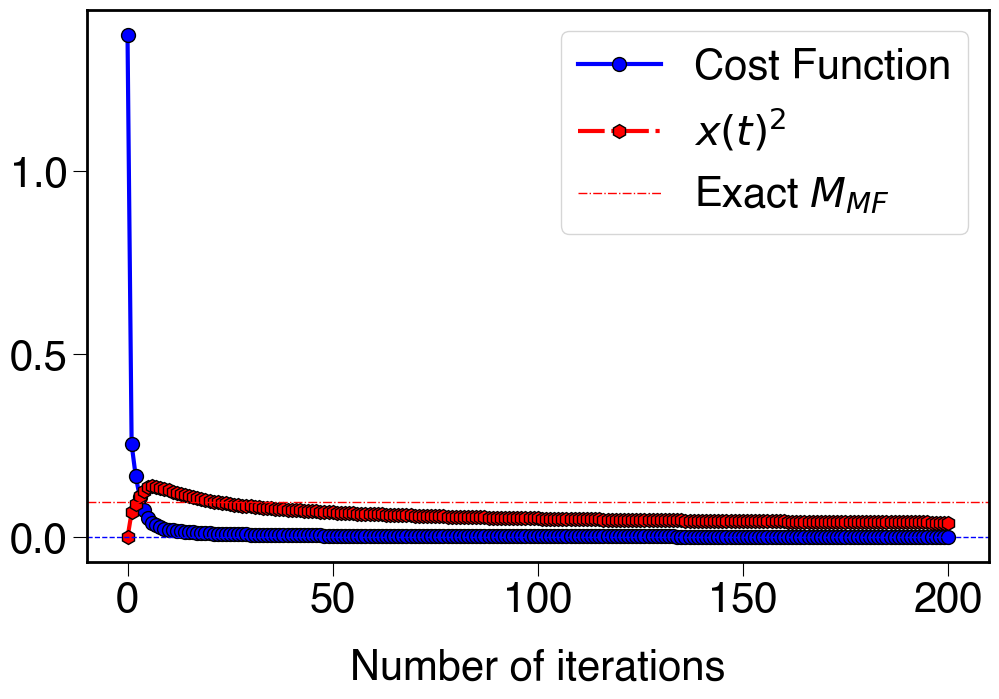

In [22]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(cost_values, marker='o', linestyle='-', color='blue', markersize=10, markerfacecolor='blue', markeredgecolor='black', linewidth=3, label='Cost Function')
print('Best cost: ', cost_values[-1])
ax.plot(np.array(x_values)**2, marker='h', linestyle='-.', color='red', markersize=10, markerfacecolor='red', markeredgecolor='black', linewidth=3, label=r'$x(t)^{2}$')
plt.axhline(y=0, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=x_steady_state**2, color='red', linestyle='-.', linewidth=1, label=r'Exact $M_{MF}$')
ax.set_xlabel('Number of iterations', labelpad=20)
#ax.set_ylabel('Cost', labelpad=20)
ax.legend()
plt.tight_layout()
for spine in ax.spines.values():
     spine.set_linewidth(2)
ax.tick_params(axis='both', which='major', length=10)
# path = '/Users/sasankadowarah/Ultimate_QM_MM/VQA/'
# os.chdir(path)
# plt.savefig('cost_function_vs_iterations.png', dpi=600, bbox_inches='tight')
plt.show()

# Density matrix parameters as function of iterations

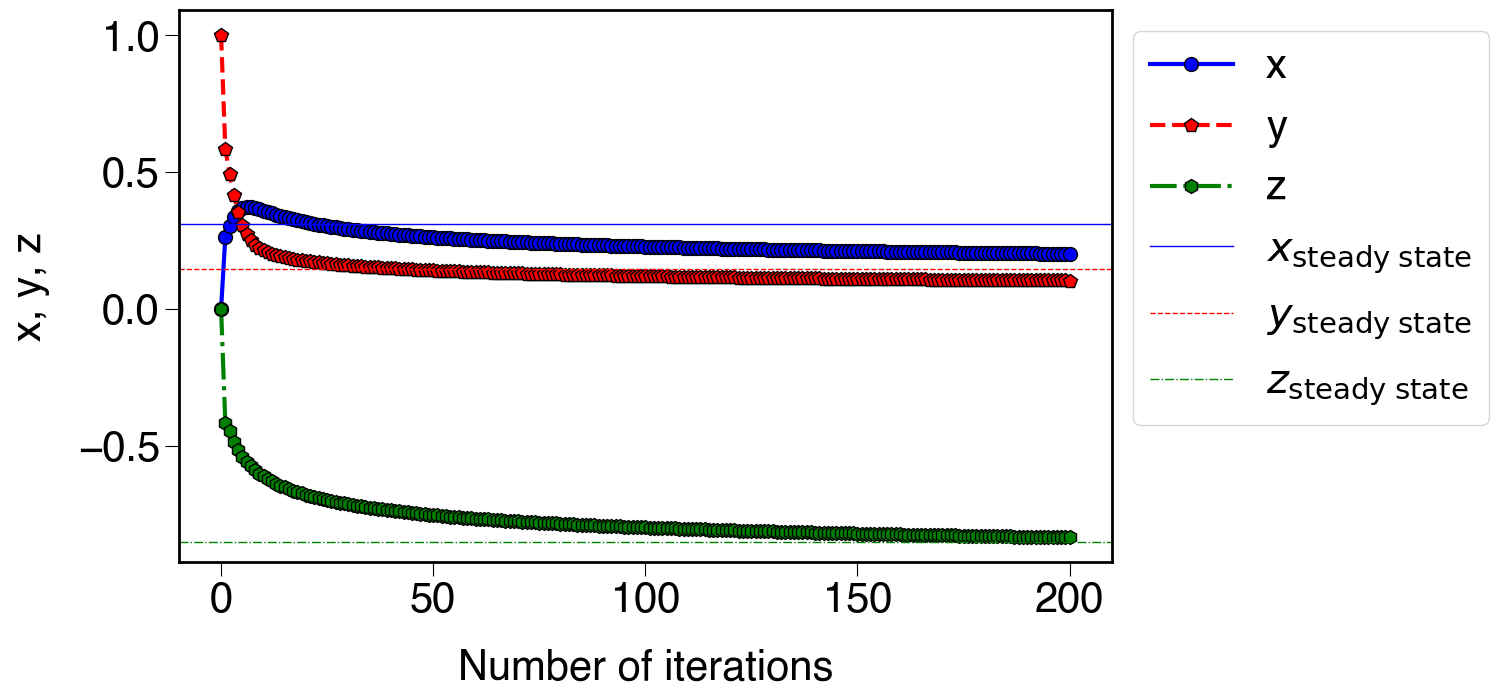

In [23]:
x_lst = []
y_lst = []
z_lst = []
for rho in rho_values:
     x_lst.append(np.real((sigma_x @ unvectorize_rho(rho)).diagonal().sum()))
     y_lst.append(np.real((sigma_y @ unvectorize_rho(rho)).diagonal().sum()))
     z_lst.append(np.real((sigma_z @ unvectorize_rho(rho)).diagonal().sum()))

# Plotting the x, y, z values over iterations with publication-quality settings.
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(x_lst, marker='o', linestyle='-', color='blue', markersize=10, markerfacecolor='blue', markeredgecolor='black', linewidth=3, label='x')
ax.plot(y_lst, marker='p', linestyle='--', color='red', markersize=10, markerfacecolor='red', markeredgecolor='black', linewidth=3, label='y')
ax.plot(z_lst, marker='h', linestyle='-.', color='green', markersize=10, markerfacecolor='green', markeredgecolor='black', linewidth=3, label='z')

plt.axhline(y=x_steady_state, color='blue', linestyle='-', linewidth=1, label=r'$x_{\mathrm{steady\; state}}$')
plt.axhline(y=y_steady_state, color='red', linestyle='--', linewidth=1, label=r'$y_{\mathrm{steady\; state}}$')
plt.axhline(y=z_steady_state, color='green', linestyle='-.', linewidth=1, label=r'$z_{\mathrm{steady\; state}}$')
ax.set_xlabel('Number of iterations', labelpad=20)
ax.set_ylabel('x, y, z', labelpad=20)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
for spine in ax.spines.values():
     spine.set_linewidth(2)
ax.tick_params(axis='both', which='major', length=10)
# path = '/Users/sasankadowarah/Ultimate_QM_MM/VQA/'
# os.chdir(path)
# plt.savefig('x_y_z_vs_iterations.png', dpi=600, bbox_inches='tight')
plt.show()

In [24]:
print('Steady state values from the density matrix:', x_lst[-1], y_lst[-1], z_lst[-1])

Steady state values from the density matrix: 0.20064211961513267 0.10310359159586707 -0.8355954814631171
